In [1]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc
from utils import log10eaxis, logjacob, makedist, makelogjacob, bkgdist, edisp, offsetaxis, fake_signal_position_dist, inverse_transform_sampling, psf, norme_vals_mesh, normoffset_vals_mesh, setup_full_fake_signal_dist, calcirfvals
from utils import psffull, evaluateintegral, evaluateformass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
sys.path.append("BFCalc")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test and Setup

In [2]:
offsetvals = np.linspace(-3.5,3.5,8)
logevals = np.linspace(-1,2,31)
offsetvalsmesh, logevalsmesh = np.meshgrid(offsetaxis, log10eaxis)


colormap = cm.get_cmap('coolwarm')

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_9793/1171364216.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('coolwarm')


In [3]:
# edispmatrix = np.empty(shape=(log10eaxis.shape[0], log10eaxis.shape[0]))

# for ii, log10eval in notebook_tqdm(enumerate(log10eaxis), total=log10eaxis.shape[0]):
#     edispmatrix[ii,:] = edisp(log10eaxis, log10eval, 1.5)



In [4]:
# plt.figure()
# plt.pcolor(log10eaxis, log10eaxis, edispmatrix, vmin=np.max(edispmatrix)-5, vmax = np.max(edispmatrix))
# plt.colorbar()
# plt.show()

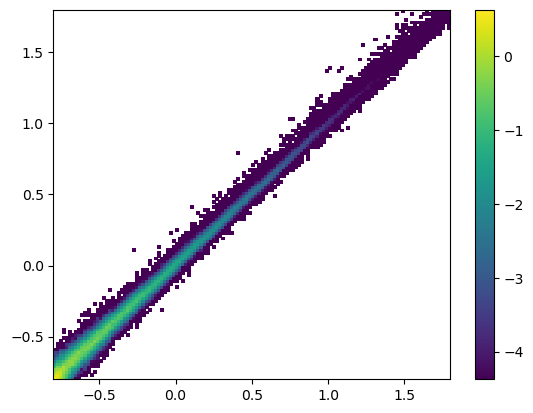

In [5]:
# psfmatrix = np.empty(shape=(offsetaxis.shape[0], offsetaxis.shape[0]))

# for ii, offsetval in notebook_tqdm(enumerate(offsetaxis), total=offsetaxis.shape[0]):
#     psfmatrix[ii,:] = psf(offsetaxis, offsetval, -0.9)

In [6]:
# plt.figure()
# plt.pcolor(offsetaxis, offsetaxis, psfmatrix)
# plt.show()

# Simulation

In [7]:
log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)
Nsamples=int(1e2)
truelambda = 0.5
nsig = int(round(truelambda*Nsamples))
nbkg = int(round((1-truelambda)*Nsamples))

truelogmassval = 1.0

In [8]:
sigpriorvalues = []

for ii, logeval in enumerate(log10eaxis):
    singlerow = setup_full_fake_signal_dist(truelogmassval, specsetup=DM_spectrum_setup, normeaxis=10**log10eaxis)(logeval, offsetaxis)
    sigpriorvalues.append(singlerow)
sigpriorvalues = np.array(sigpriorvalues)
    

/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor


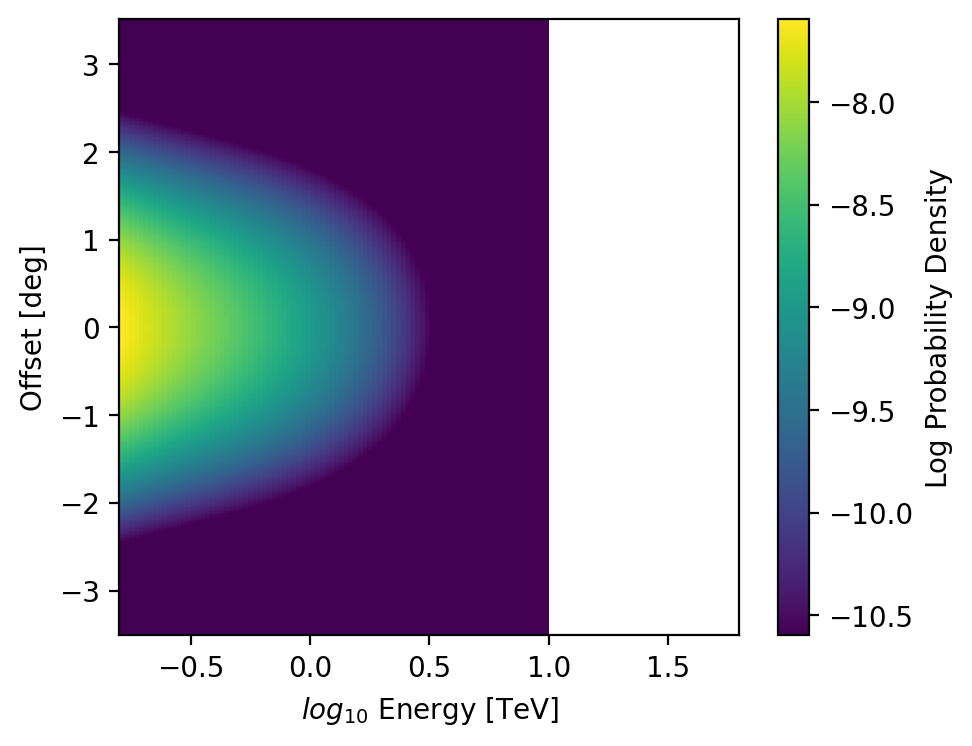

In [9]:
plt.figure(figsize=(10,5), dpi=200)
plt.subplot(1,2,1)
plt.pcolormesh(log10eaxis, offsetaxis, np.array(sigpriorvalues).T, vmin=np.max(np.array(sigpriorvalues))-3, vmax=np.max(np.array(sigpriorvalues)))
plt.xlabel(r'$log_{10}$ Energy [TeV]')
plt.ylabel('Offset [deg]')
plt.colorbar(label='Log Probability Density')


plt.subplot(1,2,2)
plt.pcolormesh(log10eaxis, offsetaxis, np.array(sigpriorvalues).T, vmin=np.max(np.array(sigpriorvalues))-3, vmax=np.max(np.array(sigpriorvalues)))
plt.xlabel(r'$log_{10}$ Energy [TeV]')
plt.ylabel('Offset [deg]')
plt.colorbar(label='Log Probability Density')

In [10]:
sigbinnedprior = sigpriorvalues.T+logjacob
flattened_sigbinnedprior = sigbinnedprior.flatten()

## Checking signal prior normalisation

In [11]:
special.logsumexp(sigbinnedprior)

0.0

In [12]:


sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_sigbinnedprior, Nsamples=Nsamples),sigbinnedprior.shape)
siglogevals = log10eaxis[sigresultindices[1]]
sigoffsetvals = offsetaxis[sigresultindices[0]]

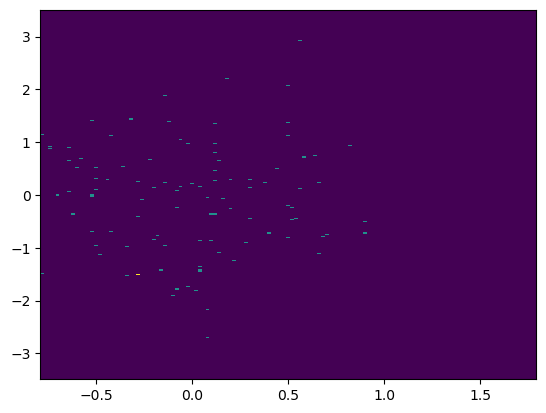

In [13]:
plt.figure()
plt.hist2d(siglogevals, sigoffsetvals, bins=[log10eaxis, offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0])])
# for val in offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0]):
#     plt.axhline(val, alpha=0.1, c='tab:orange')
plt.show()

In [14]:
signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, offsetval)+logjacob, Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=Nsamples)])]

  0%|          | 0/100 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 100/100 [00:06<00:00, 14.39it/s]


In [15]:
signal_offset_measured = offsetaxis[np.squeeze([inverse_transform_sampling(psf(offsetaxis, offsetval, logeval), Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=Nsamples)])]


  0%|          | 0/100 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:77: RuntimeWarning: divide by zero encountered in log
  psffunc = lambda offsetrecon: np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


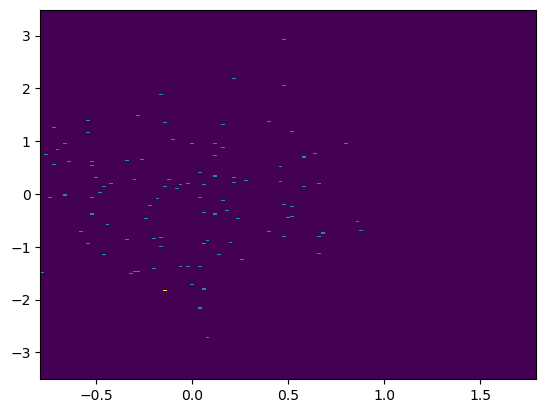

100.0

In [16]:
plt.figure()
histvals = plt.hist2d(signal_log10e_measured, signal_offset_measured, bins=[log10eaxis, offsetaxis-0.5*(offsetaxis[1]-offsetaxis[0])])
plt.show()

np.sum(histvals[0])

# Nuisance Parameter Marginalisation

In [27]:
sigdistsetup = setup_full_fake_signal_dist
# Makes it so that when np.log(0) is called a warning isn't raised as well as other errors stemming from this.
np.seterr(divide='ignore', invalid='ignore')


true_offset_vals             = np.array(list(sigoffsetvals)+list([]))
measured_offset_vals         = np.array(list(signal_offset_measured)+list([]))
true_log10e_vals             = np.array(list(siglogevals)+list([]))
measured_log10e_vals         = np.array(list(signal_log10e_measured)+list([]))

numcores                = 10
nbinslogmass            = 81
logmasswindowwidth      = 2/np.sqrt(Nsamples)
logmasslowerbound       = truelogmassval-logmasswindowwidth
logmassupperbound       = truelogmassval+logmasswindowwidth


if logmasslowerbound<log10eaxis[1]:
        logmasslowerbound = log10eaxis[1]
if logmassupperbound>2:
        logmassupperbound = 2


logmassrange         = np.linspace(logmasslowerbound,logmassupperbound,nbinslogmass)    

In [18]:

irfvals = []
with Pool(numcores) as pool: 
        for result in notebook_tqdm(pool.imap(calcirfvals, zip(measured_log10e_vals, measured_offset_vals)), 
                            total=len(list(measured_log10e_vals)), ncols=100, desc="Calculating irfvals"):
                irfvals.append(result)

        pool.close() 

Calculating irfvals:   0%|                                                  | 0/100 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon

In [28]:
produce_posterior_function = functools.partial(evaluateformass, irfvals=irfvals, specsetup=DM_spectrum_setup)
logmass_logposterior = []
with Pool(numcores) as pool: 
        
        for result in notebook_tqdm(pool.imap(produce_posterior_function, logmassrange), total=len(list(logmassrange)), ncols=100, desc="Calculating signal marginalisations..."):
                logmass_logposterior.append(result)

        pool.close() 

Calculating signal marginalisations...:   0%|                                | 0/81 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
/Users/lpin0002/Desktop/DMPipe/BFCalc/BFInterp.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(spectralfunc(10**logenerg)) #-normfactor
Calculating signal marginalisations...:   1%|▎                       | 1/81 [00:07<10:38,  7.98

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_9793/2847379991.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


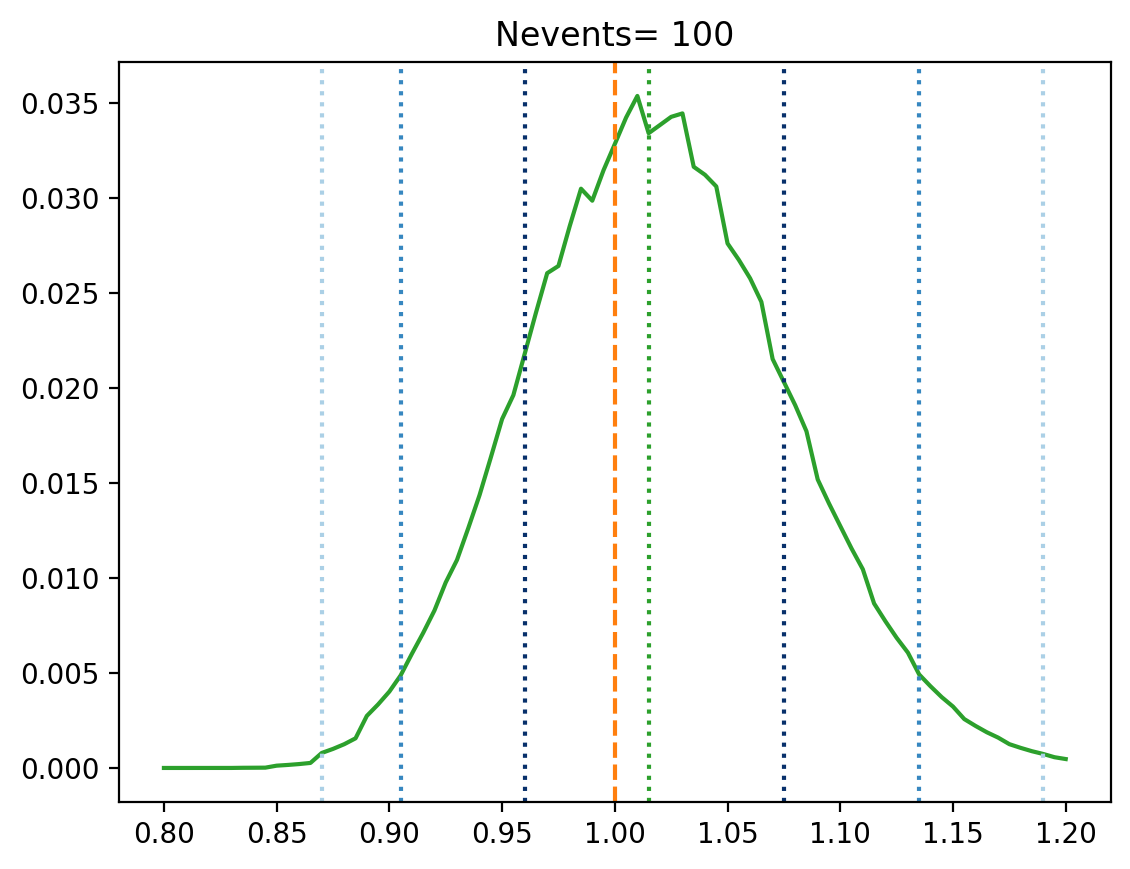

In [29]:
from scipy.stats import norm

colormap = cm.get_cmap('Blues_r', 4)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdfposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdfposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
percentiles = []
for zscore in zscores:
    percentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdfposterior).argmin()])

plt.figure(dpi=200)
plt.title(f"Nevents= {Nsamples}")
plt.plot(logmassrange,normalisedlogmassposterior, c='tab:green')

plt.axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(percentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            plt.axvline(percentile, c=color, ls=':')
plt.axvline(truelogmassval, ls='--', color="tab:orange")
plt.show()